## PyTorch neural network

In [32]:
!pip install transformers deepchem

In [33]:
!polaris login

2024-06-21 15:14:30.975 | INFO     | polaris.hub.client:login:285 - You are already logged in to the Polaris Hub as yakavetsiv (i.yakavets@gmail.com). Set `overwrite=True` to force re-authentication.


In [65]:
#Experimental Class for Smiles Enumeration, Iterator and SmilesIterator adapted from Keras 1.2.2
from rdkit import Chem
import numpy as np
import threading

class Iterator(object):
    """Abstract base class for data iterators.

    # Arguments
        n: Integer, total number of samples in the dataset to loop over.
        batch_size: Integer, size of a batch.
        shuffle: Boolean, whether to shuffle the data between epochs.
        seed: Random seeding for data shuffling.
    """

    def __init__(self, n, batch_size, shuffle, seed):
        self.n = n
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.batch_index = 0
        self.total_batches_seen = 0
        self.lock = threading.Lock()
        self.index_generator = self._flow_index(n, batch_size, shuffle, seed)
        if n < batch_size:
            raise ValueError('Input data length is shorter than batch_size\nAdjust batch_size')

    def reset(self):
        self.batch_index = 0

    def _flow_index(self, n, batch_size=32, shuffle=False, seed=None):
        # Ensure self.batch_index is 0.
        self.reset()
        while 1:
            if seed is not None:
                np.random.seed(seed + self.total_batches_seen)
            if self.batch_index == 0:
                index_array = np.arange(n)
                if shuffle:
                    index_array = np.random.permutation(n)

            current_index = (self.batch_index * batch_size) % n
            if n > current_index + batch_size:
                current_batch_size = batch_size
                self.batch_index += 1
            else:
                current_batch_size = n - current_index
                self.batch_index = 0
            self.total_batches_seen += 1
            yield (index_array[current_index: current_index + current_batch_size],
                   current_index, current_batch_size)

    def __iter__(self):
        # Needed if we want to do something like:
        # for x, y in data_gen.flow(...):
        return self

    def __next__(self, *args, **kwargs):
        return self.next(*args, **kwargs)




class SmilesIterator(Iterator):
    """Iterator yielding data from a SMILES array.

    # Arguments
        x: Numpy array of SMILES input data.
        y: Numpy array of targets data.
        smiles_data_generator: Instance of `SmilesEnumerator`
            to use for random SMILES generation.
        batch_size: Integer, size of a batch.
        shuffle: Boolean, whether to shuffle the data between epochs.
        seed: Random seed for data shuffling.
        dtype: dtype to use for returned batch. Set to keras.backend.floatx if using Keras
    """

    def __init__(self, x, y, smiles_data_generator,
                 batch_size=32, shuffle=False, seed=None,
                 dtype=np.float32
                 ):
        if y is not None and len(x) != len(y):
            raise ValueError('X (images tensor) and y (labels) '
                             'should have the same length. '
                             'Found: X.shape = %s, y.shape = %s' %
                             (np.asarray(x).shape, np.asarray(y).shape))

        self.x = np.asarray(x)

        if y is not None:
            self.y = np.asarray(y)
        else:
            self.y = None
        self.smiles_data_generator = smiles_data_generator
        self.dtype = dtype
        super(SmilesIterator, self).__init__(x.shape[0], batch_size, shuffle, seed)

    def next(self):
        """For python 2.x.

        # Returns
            The next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
        # The transformation of images is not under thread lock
        # so it can be done in parallel
        batch_x = np.zeros(tuple([current_batch_size] + [ self.smiles_data_generator.pad, self.smiles_data_generator._charlen]), dtype=self.dtype)
        for i, j in enumerate(index_array):
            smiles = self.x[j:j+1]
            x = self.smiles_data_generator.transform(smiles)
            batch_x[i] = x

        if self.y is None:
            return batch_x
        batch_y = self.y[index_array]
        return batch_x, batch_y


class SmilesEnumerator(object):
    """SMILES Enumerator, vectorizer and devectorizer
    
    #Arguments
        charset: string containing the characters for the vectorization
          can also be generated via the .fit() method
        pad: Length of the vectorization
        leftpad: Add spaces to the left of the SMILES
        isomericSmiles: Generate SMILES containing information about stereogenic centers
        enum: Enumerate the SMILES during transform
        canonical: use canonical SMILES during transform (overrides enum)
    """
    def __init__(self, charset = '@C)(=cOn1S2/H[N]\\', pad=120, leftpad=True, isomericSmiles=True, enum=True, canonical=False):
        self._charset = None
        self.charset = charset
        self.pad = pad
        self.leftpad = leftpad
        self.isomericSmiles = isomericSmiles
        self.enumerate = enum
        self.canonical = canonical

    @property
    def charset(self):
        return self._charset
        
    @charset.setter
    def charset(self, charset):
        self._charset = charset
        self._charlen = len(charset)
        self._char_to_int = dict((c,i) for i,c in enumerate(charset))
        self._int_to_char = dict((i,c) for i,c in enumerate(charset))
        
    def fit(self, smiles, extra_chars=[], extra_pad = 5):
        """Performs extraction of the charset and length of a SMILES datasets and sets self.pad and self.charset
        
        #Arguments
            smiles: Numpy array or Pandas series containing smiles as strings
            extra_chars: List of extra chars to add to the charset (e.g. "\\\\" when "/" is present)
            extra_pad: Extra padding to add before or after the SMILES vectorization
        """
        charset = set("".join(list(smiles)))
        self.charset = "".join(charset.union(set(extra_chars)))
        self.pad = max([len(smile) for smile in smiles]) + extra_pad
        
    def randomize_smiles(self, smiles):
        """Perform a randomization of a SMILES string
        must be RDKit sanitizable"""
        m = Chem.MolFromSmiles(smiles)
        ans = list(range(m.GetNumAtoms()))
        np.random.shuffle(ans)
        nm = Chem.RenumberAtoms(m,ans)
        return Chem.MolToSmiles(nm, canonical=self.canonical, isomericSmiles=self.isomericSmiles)

    def transform(self, smiles):
        """Perform an enumeration (randomization) and vectorization of a Numpy array of smiles strings
        #Arguments
            smiles: Numpy array or Pandas series containing smiles as strings
        """
        one_hot =  np.zeros((smiles.shape[0], self.pad, self._charlen),dtype=np.int8)
        
        if self.leftpad:
            for i,ss in enumerate(smiles):
                if self.enumerate: ss = self.randomize_smiles(ss)
                l = len(ss)
                diff = self.pad - l
                for j,c in enumerate(ss):
                    one_hot[i,j+diff,self._char_to_int[c]] = 1
            return one_hot
        else:
            for i,ss in enumerate(smiles):
                if self.enumerate: ss = self.randomize_smiles(ss)
                for j,c in enumerate(ss):
                    one_hot[i,j,self._char_to_int[c]] = 1
            return one_hot

      
    def reverse_transform(self, vect):
        """ Performs a conversion of a vectorized SMILES to a smiles strings
        charset must be the same as used for vectorization.
        #Arguments
            vect: Numpy array of vectorized SMILES.
        """       
        smiles = []
        for v in vect:
            #mask v 
            v=v[v.sum(axis=1)==1]
            #Find one hot encoded index with argmax, translate to char and join to string
            smile = "".join(self._int_to_char[i] for i in v.argmax(axis=1))
            smiles.append(smile)
        return np.array(smiles)

In [35]:
# @title Set an owner
owner = 'qumark' # @param {type:"string"}
print(f"You have set \"{owner}\" as the owner")

You have set "qumark" as the owner


In [36]:
from functools import partial

import polaris as po
import datamol as dm
import matplotlib.pyplot as plt
import numpy as np

In [37]:
benchmark = po.load_benchmark("polaris/pkis1-kit-wt-mut-c-1")
train, test = benchmark.get_train_test_split()

2024-06-21 15:14:32.822 | INFO     | polaris._artifact:_validate_version:66 - The version of Polaris that was used to create the artifact (0.0.0) is different from the currently installed version of Polaris (dev).
2024-06-21 15:14:32.827 | INFO     | polaris._artifact:_validate_version:66 - The version of Polaris that was used to create the artifact (0.0.0) is different from the currently installed version of Polaris (dev).


In [38]:
target_order = ['CLASS_KIT', 'CLASS_KIT_(T6701_mutant)', 'CLASS_KIT_(V560G_mutant)']

ys = train.y
ys = np.stack([ys[target] for target in target_order], axis=1)
ys.shape

# remove the rows with NaN values
mask = ~np.any(np.isnan(ys), axis=1)
mask.sum()
X = train.X[mask]
ys = ys[mask]

## Augmenting SMILES data

There is only 30 binders.
There's 216 class 1 datapoints missing.


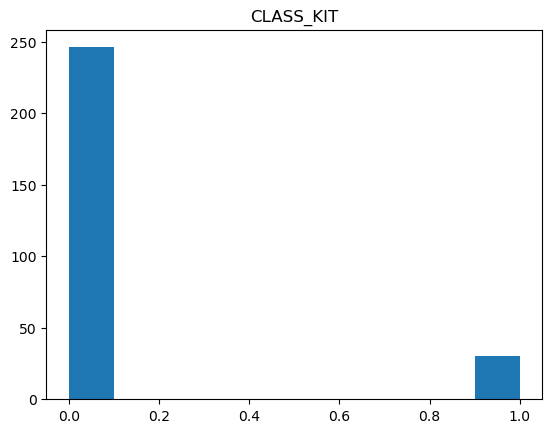

In [39]:
plt.hist(ys[:, 0])
num_class1 = list(ys[:, 0] == 1.0).count(True)
print(f"There is only {num_class1} binders.")
plt.title(target_order[0])

num_class0 = list(ys[:, 0] == 0.0).count(True)
num_missing = num_class0 - num_class1
print(f"There's {num_missing} class 1 datapoints missing.")

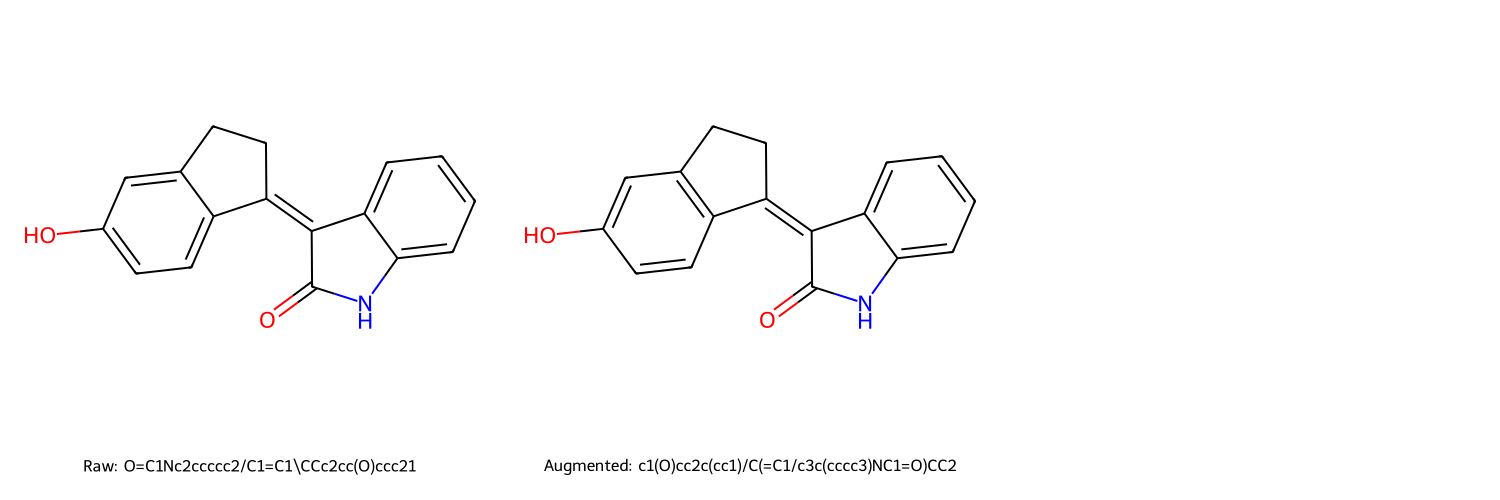

In [40]:
## Balancing SMILES-based dataset

import random
from rdkit.Chem import Draw

class1_samples = [(x_,y_) for x_, y_ in zip(X, ys) if y_[0] == 1.0]

sme = SmilesEnumerator()
for _ in range(num_missing):
    sample = random.sample(class1_samples, k=1)
    randomized_x = sme.randomize_smiles(sample[0][0])
    X = np.append(X, randomized_x)
    ys = np.append(ys, [sample[0][1]])

ys = ys.reshape(-1, 3)
mols = [Chem.MolFromSmiles(sample[0][0]), Chem.MolFromSmiles(randomized_x)]
Draw.MolsToGridImage(mols, subImgSize=(500, 500), legends=[f"Raw: {sample[0][0]}", f"Augmented: {randomized_x}"])

There is now 246 binders and 246 non-binders.


Text(0.5, 1.0, 'CLASS_KIT')

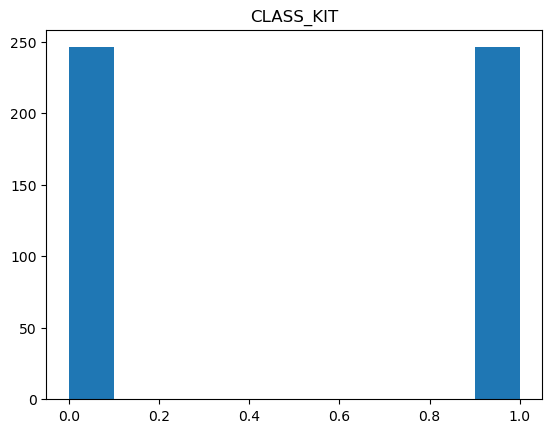

In [41]:
plt.hist(ys[:, 0])
num_binders = list(ys[:, 0] == 1.0).count(True)
num_nonbinders = list(ys[:, 0] == 0.0).count(True)
print(f"There is now {num_binders} binders and {num_nonbinders} non-binders.")
plt.title(target_order[0])

## Tokenizing SMILES

In [42]:
import os

from deepchem.feat.smiles_tokenizer import SmilesTokenizer
import torch

In [43]:
tokenizer = SmilesTokenizer('vocab.txt')

In [44]:
tokenized_X = [tokenizer.encode(smiles, padding="max_length", max_length=81) for smiles in X]
tokenized_X = np.array(tokenized_X)

In [45]:
tokenized_X

array([[12, 19, 22, ...,  0,  0,  0],
       [12, 16, 16, ...,  0,  0,  0],
       [12, 16, 23, ...,  0,  0,  0],
       ...,
       [12, 15, 20, ...,  0,  0,  0],
       [12, 25, 20, ...,  0,  0,  0],
       [12, 15, 20, ...,  0,  0,  0]])

## PyTorch model

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the SMILES neural network
class SMILESNeuralNet(nn.Module):
    
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(SMILESNeuralNet, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        embedded = self.embedding(x)
        embedded = embedded.mean(dim=1)  # Do we need averaging of embeddings?
        out = self.fc1(embedded)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out) # binarize the output
        return out

# Hyperparameters
vocab_size = tokenizer.vocab_size
embed_dim = 32
hidden_dim = 64
output_dim = 1  # For now we only want binary classification

# Instantiate the model, loss function, and optimizer
model = SMILESNeuralNet(vocab_size, embed_dim, hidden_dim, output_dim)
criterion = nn.BCELoss()  # Using BCELoss since we're doing binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_tokens = torch.from_numpy(tokenized_X)
targets = torch.from_numpy(ys[:, 0].astype(dtype=np.float32))

# Training loop (simplified)
num_epochs = 7500
loss_over_time = []
for epoch in range(num_epochs):
    # Zero the parameter gradients
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(X_tokens)
    loss = criterion(outputs.squeeze(), targets)
    loss_over_time.append(loss)
    
    # Backward pass and optimize
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training complete.")

Epoch [10/7500], Loss: 0.6876
Epoch [20/7500], Loss: 0.6808
Epoch [30/7500], Loss: 0.6727
Epoch [40/7500], Loss: 0.6623
Epoch [50/7500], Loss: 0.6485
Epoch [60/7500], Loss: 0.6315
Epoch [70/7500], Loss: 0.6118
Epoch [80/7500], Loss: 0.5904
Epoch [90/7500], Loss: 0.5688
Epoch [100/7500], Loss: 0.5488
Epoch [110/7500], Loss: 0.5307
Epoch [120/7500], Loss: 0.5145
Epoch [130/7500], Loss: 0.4998
Epoch [140/7500], Loss: 0.4864
Epoch [150/7500], Loss: 0.4742
Epoch [160/7500], Loss: 0.4629
Epoch [170/7500], Loss: 0.4524
Epoch [180/7500], Loss: 0.4425
Epoch [190/7500], Loss: 0.4333
Epoch [200/7500], Loss: 0.4246
Epoch [210/7500], Loss: 0.4163
Epoch [220/7500], Loss: 0.4083
Epoch [230/7500], Loss: 0.4007
Epoch [240/7500], Loss: 0.3934
Epoch [250/7500], Loss: 0.3863
Epoch [260/7500], Loss: 0.3794
Epoch [270/7500], Loss: 0.3727
Epoch [280/7500], Loss: 0.3662
Epoch [290/7500], Loss: 0.3598
Epoch [300/7500], Loss: 0.3536
Epoch [310/7500], Loss: 0.3475
Epoch [320/7500], Loss: 0.3416
Epoch [330/7500],

Text(0, 0.5, 'Loss')

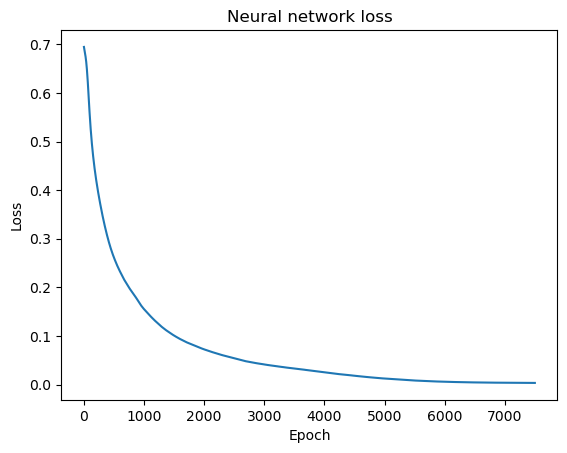

In [59]:
plt.plot(list(range(num_epochs)), [l.detach().numpy() for l in loss_over_time])
plt.title("Neural network loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [60]:
model.eval()  # set to evaluation mode for inference time

tokenized_test_X = [tokenizer.encode(smiles, padding="max_length", max_length=81) for smiles in test.X]
tokenized_test_X = np.array(tokenized_test_X)
tokenized_test_X = torch.from_numpy(tokenized_test_X)  # to tensor

# Perform inference
with torch.no_grad():  # turn off gradient calculation
    predictions = model(tokenized_test_X)
    predictions = predictions.squeeze().numpy()  # convert to numpy
    
print("Predictions:", predictions)

Predictions: [1.2599114e-14 5.0509341e-12 6.8454709e-16 1.1266869e-06 2.8111086e-11
 8.4950194e-16 4.7685580e-06 1.3095759e-29 5.1210917e-11 2.6970431e-32
 3.0490771e-35 1.8141000e-21 2.6851570e-12 1.6078199e-17 3.2664049e-01
 2.3166996e-03 2.4164107e-13 7.7662335e-08 3.7024539e-27 0.0000000e+00
 6.2605416e-15 2.8329043e-04 1.3410532e-26 1.0000000e+00 1.4156354e-05
 3.8288934e-21 2.0886815e-04 2.0737153e-18 6.8425452e-09 4.2579579e-11
 1.0000000e+00 2.2169726e-30 1.0000000e+00 2.0400682e-03 1.1820020e-15
 5.9143019e-09 9.9999380e-01 8.7553838e-25 9.9134374e-01 7.9398023e-06
 9.8626709e-01 1.8283304e-02 4.4942542e-08 3.2671514e-14 4.8733839e-10
 6.6409199e-13 1.0509051e-06 4.9506570e-04 4.4265690e-08 2.9670218e-07
 4.7975695e-01 1.1446512e-25 1.0053858e-22 1.2059318e-14 9.9999797e-01
 8.3912001e-04 9.7434580e-01 2.6487814e-12 9.9996424e-01 9.1996410e-10
 9.1169596e-30 9.9966300e-01 1.7421126e-01 1.0297962e-09 2.0997970e-22
 1.2777989e-32 6.8574727e-01 9.9829477e-01 2.7221111e-03 1.29901

In [61]:
# binarize the predictions
predicted_labels = (predictions > 0.5).astype(np.float32)

In [62]:
y_prob = {"CLASS_KIT": predictions, 'CLASS_KIT_(T6701_mutant)': predictions, 'CLASS_KIT_(V560G_mutant)': predictions}
y_pred = {"CLASS_KIT": predicted_labels, 'CLASS_KIT_(T6701_mutant)': predicted_labels, 'CLASS_KIT_(V560G_mutant)': predicted_labels}

results = benchmark.evaluate(y_pred=y_pred, y_prob=y_prob)

In [63]:
results

{
  "name": null,
  "description": "",
  "tags": [],
  "user_attributes": {},
  "owner": null,
  "polaris_version": "dev",
  "benchmark_name": "pkis1-kit-wt-mut-c-1",
  "benchmark_owner": {
    "slug": "polaris",
    "external_id": "org_2gtoaJIVrgRqiIR8Qm5BnpFCbxu",
    "type": "organization"
  },
  "github_url": null,
  "paper_url": null,
  "contributors": null,
  "artifact_id": null,
  "benchmark_artifact_id": "polaris/pkis1-kit-wt-mut-c-1",
  "results": [
    {
      "Test set": "test",
      "Target label": "CLASS_KIT_(T6701_mutant)",
      "Metric": "accuracy",
      "Score": 0.724137931
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT_(V560G_mutant)",
      "Metric": "accuracy",
      "Score": 0.7931034483
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT",
      "Metric": "accuracy",
      "Score": 0.5977011494
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT_(T6701_mutant)",
      "Metric": "f1",
      "Score": 0.1428571429
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT_(V560G_mutant)",
      "Metric": "f1",
      "Score": 0.3076923077
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT",
      "Metric": "f1",
      "Score": 0.2553191489
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT_(T6701_mutant)",
      "Metric": "roc_auc",
      "Score": 0.5410958904
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT_(V560G_mutant)",
      "Metric": "roc_auc",
      "Score": 0.7238888889
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT",
      "Metric": "roc_auc",
      "Score": 0.5679012346
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT_(T6701_mutant)",
      "Metric": "pr_auc",
      "Score": 0.2226757568
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT_(V560G_mutant)",
      "Metric": "pr_auc",
      "Score": 0.3861047807
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT",
      "Metric": "pr_auc",
      "Score": 0.5086564538
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT_(T6701_mutant)",
      "Metric": "mcc",
      "Score": -0.0215264188
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT_(V560G_mutant)",
      "Metric": "mcc",
      "Score": 0.1876833741
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT",
      "Metric": "mcc",
      "Score": 0.0444602553
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT_(T6701_mutant)",
      "Metric": "cohen_kappa",
      "Score": -0.0215264188
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT_(V560G_mutant)",
      "Metric": "cohen_kappa",
      "Score": 0.1869158879
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT",
      "Metric": "cohen_kappa",
      "Score": 0.0379146919
    }
  ]
}

## Outstanding TODOs

- Perform joint embedding with the target
- Hyperparameter tuning